In [1]:
# Import the packages we will use
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math

In [2]:
# The following directive activates inline plotting
%matplotlib inline

###### Select chromose to work with

In [3]:
chr_index = 1
chr = 'chr' + str(chr_index)

In [4]:
def plot_HiC(arr, figsize=(15,15)):
    '''
        Plot Hi-С map in blue-red colormap
        Function returns ax to add smth in the figure if needed
    '''
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    im = ax.matshow(arr, cmap='RdBu_r')
    fig.colorbar(im)
    return ax

###### Read loops coordinates, sizes and etc

In [5]:
loops_info = pandas.read_csv('GSE63525_GM12878_primary+replicate_HiCCUPS_looplist.txt', sep='\t',
                             dtype = {'x1': np.long, 'x2': np.long, 'y1': np.long, 'y2': np.long})
loops = loops_info[loops_info.chr1 == str(chr_index)]

### 10kb resolution

In [6]:
resolution = 10**4

arr_10kb = np.load('arrs/10kb_' + str(chr_index) + 'chr.npy')
arr_10kb_log = np.load('arrs/10kb_' + str(chr_index) + 'chr_log.npy')
arr_10kb_norm = np.load('arrs/10kb_' + str(chr_index) + 'chr_norm.npy')
arr_10kb_norm_log = np.load('arrs/10kb_' + str(chr_index) + 'chr_norm_log.npy')

Normalized map was produced by function:
It divides each diagonal of a Hi-C contact map by its' mean.  
It also does it in a smart way: it calculates averages over stripes from X to X*1.05, and divides each stripe by its mean.  
It allows to avoid divergence far from the main diagonal with a very few reads.  
(comment from __mirnylib__)

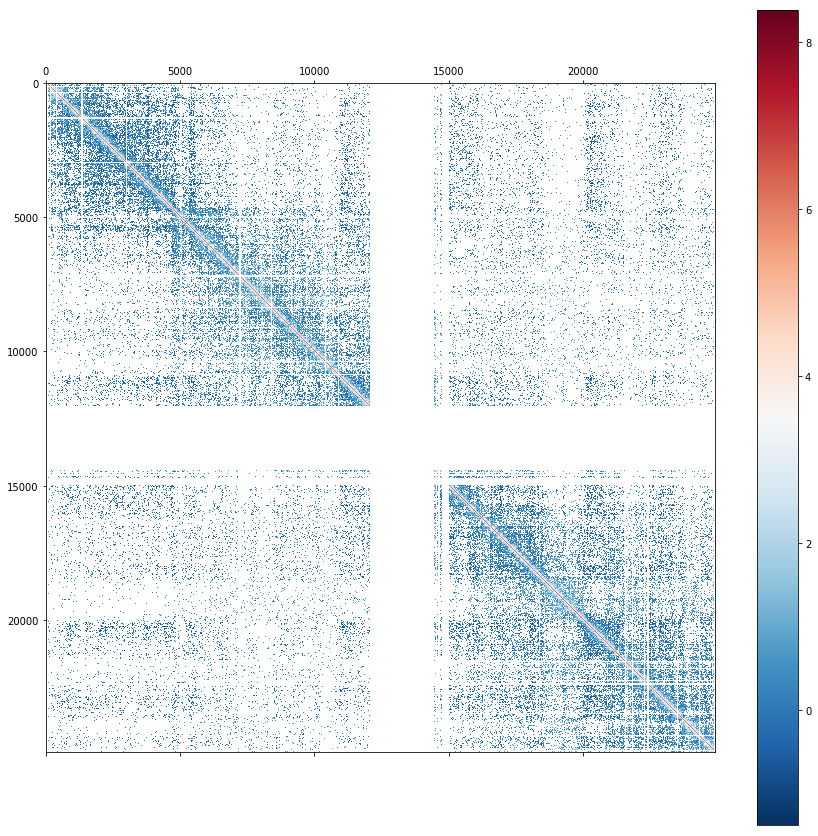

In [7]:
plot_HiC(arr_10kb_log)

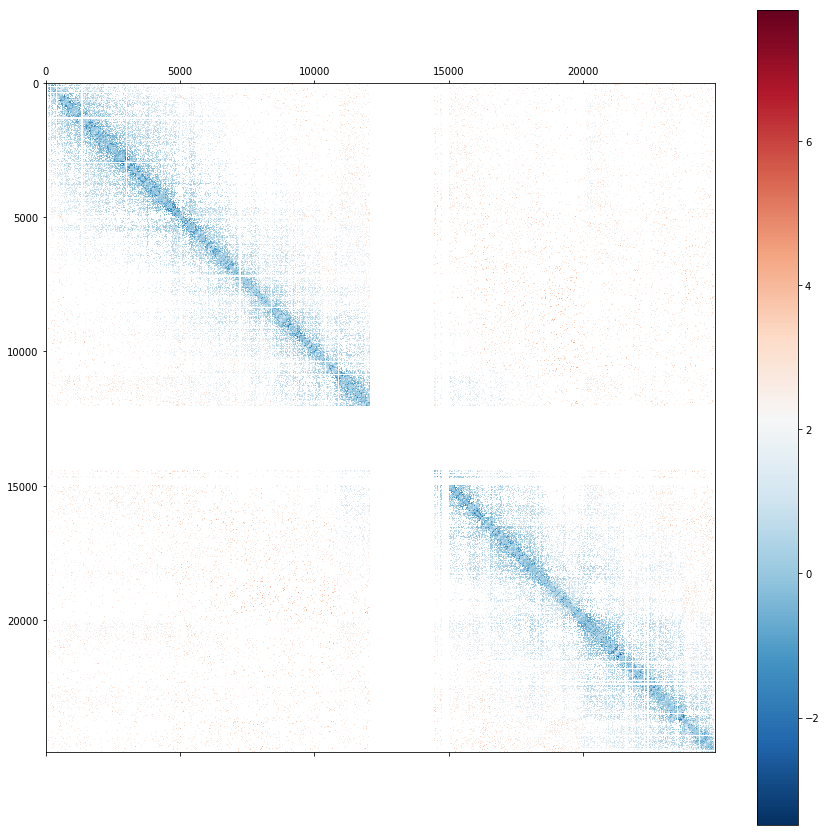

In [8]:
plot_HiC(arr_10kb_norm_log)

#### Loops on Hi-C

In [9]:
def plot_loops_on_hic_matrix(arr, resolution, loops_info, start = 0, end = -1):     
    '''
        plot loops with boundaries on a HiC map
    '''
    ax = plot_HiC(arr[start:end, start:end])

    for index, row in loops_info.iterrows():

        # the coordinates of the upstream locus corresponding to the peak pixel
        x1 = int(row['x1']/resolution)-start-.5
        x2 = int(row['x2']/resolution)-start-.5

        # the coordinates of the downstream locus corresponding to the peak pixel
        y1 = int(row['y1']/resolution)-start+0.5
        y2 = int(row['y2']/resolution)-start+0.5

        loop_y_centroid = int(row['centroid1']/resolution) - start
        loop_x_centroid = int(row['centroid2']/resolution) - start
        loop_radius = row['radius']/resolution

        loop_center = (loop_x_centroid, loop_y_centroid)

        ## loop as a circle with center in @loop_center with radius @loop_radius
        loop = matplotlib.patches.Circle(loop_center, loop_radius,
                                         fill=None, alpha=1,
                                         edgecolor='lime', linewidth=2.0)
        ax.add_patch(loop)

        ## areas with start locus and end locus
        loop_tr = matplotlib.patches.Rectangle((x2, x1), y2-x2, y1-x1, 
                                               fill=None, alpha=1,
                                               edgecolor='black', linewidth=.5)
        ax.add_patch(loop_tr)

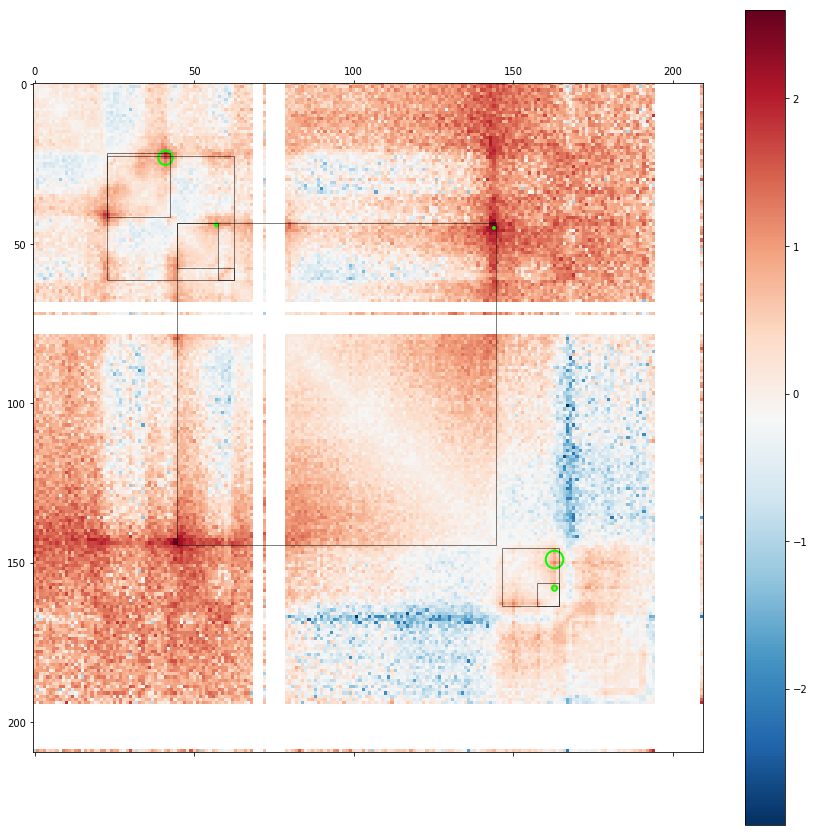

In [10]:
plot_loops_on_hic_matrix(arr_10kb_norm_log, resolution, loops, start = 190, end = 400)

### 5kb resolution

In [11]:
arr_5kb_norm = np.load('arrs/5kb_' + str(chr_index) + 'chr_norm.npy')
arr_5kb_norm_log = np.load('arrs/5kb_' + str(chr_index) + 'chr_norm_log.npy')
resolution = 5 * 10**3

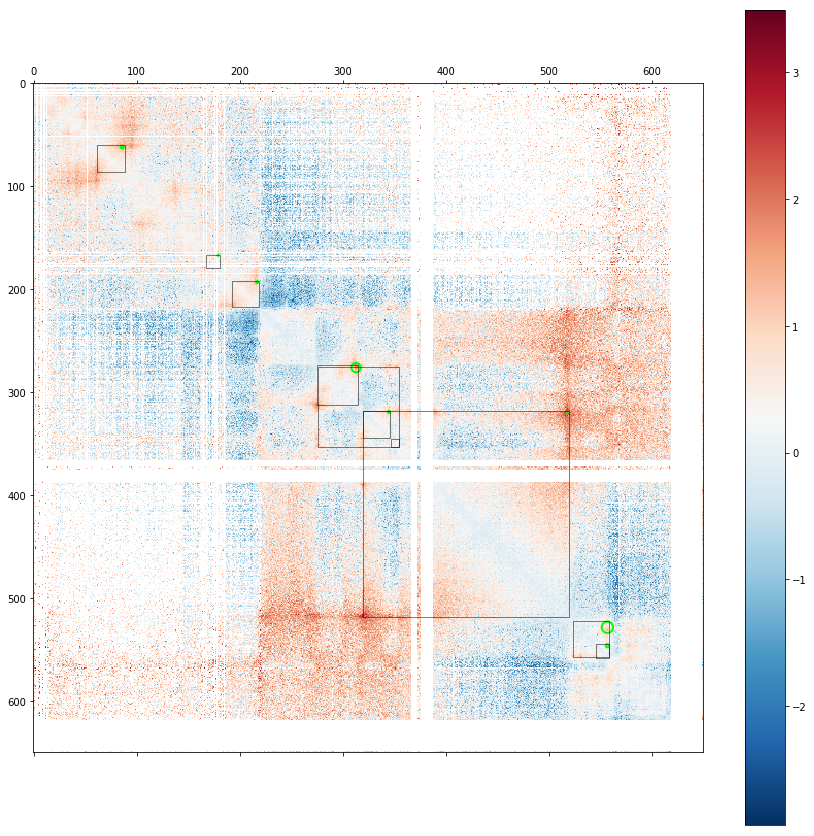

In [12]:
plot_loops_on_hic_matrix(arr_5kb_norm_log, 5*10**3, loops, start = 150, end = 800)

# 10kb resolution

In [13]:
resolution = 10**4

### Average (summary) loop

In [14]:
def get_loop_with_window(idx, window_size=13):
    
    row = loops.iloc[idx]
    
    loop_y_centroid = int(row.centroid1/resolution)
    loop_x_centroid = int(row.centroid2/resolution)
    
    loop_window_size = math.ceil(window_size/2) + 1
    loop_window = np.zeros((loop_window_size, loop_window_size))
    
    if loop_x_centroid-math.floor(window_size/2) > 0 and loop_y_centroid-math.floor(window_size/2) > 0:

        loop_window = arr[loop_y_centroid-math.floor(window_size/2):loop_y_centroid+math.ceil(window_size/2), 
                          loop_x_centroid-math.floor(window_size/2):loop_x_centroid+math.ceil(window_size/2)]

    return loop_window

In [15]:
def sum_loops(arr, *args):
    loop_sum = get_loop_with_window(0, *args)

    for idx in range(1, loops.shape[0]):
        loop_window = get_loop_with_window(idx, *args)
        loop_window[loop_window == -np.inf] = 0
        loop_sum = loop_sum + np.nan_to_num(loop_window) 
        
    return loop_sum

### Normalized

In [16]:
arr = arr_10kb_norm

###### Single loop

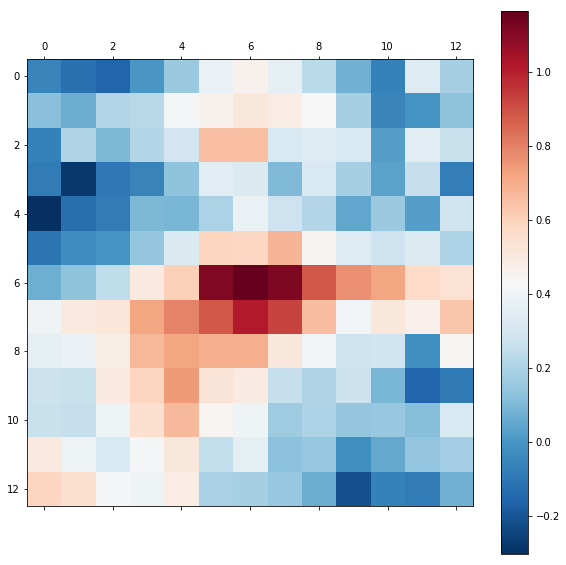

In [18]:
loop_window = get_loop_with_window(30)
plot_HiC(np.log(loop_window), figsize=(10, 10))

###### Summary loop

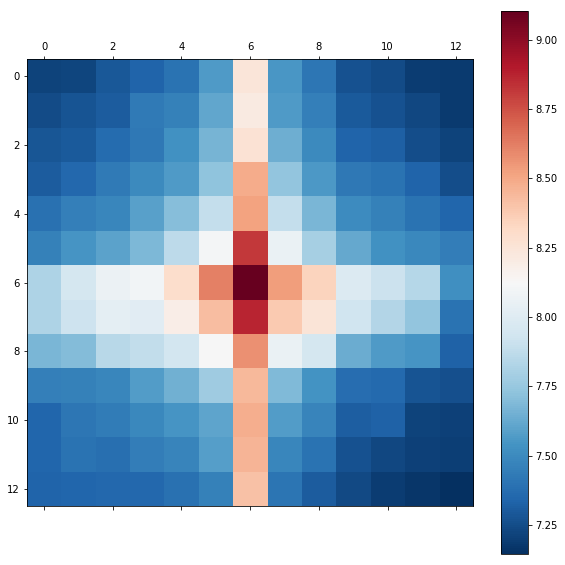

In [19]:
loop_sum = sum_loops(arr)
plot_HiC(np.log(loop_sum), figsize=(10, 10))

### Raw data

In [20]:
arr = arr_10kb

###### Single loop

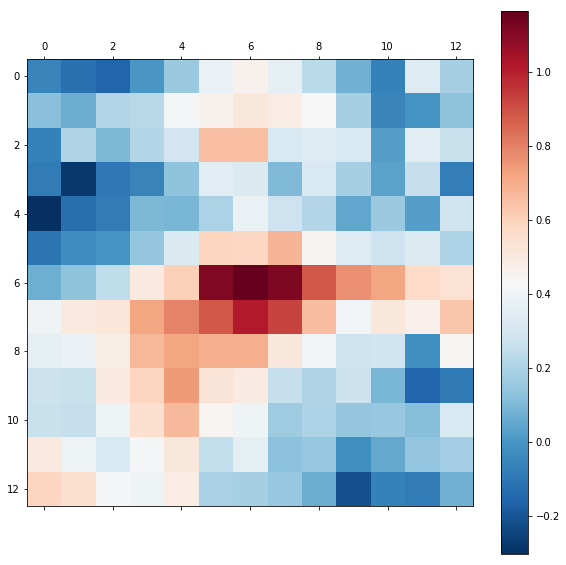

In [21]:
row = get_loop_with_window(30)
plot_HiC(np.log(loop_window), figsize=(10, 10))

###### Summary loop

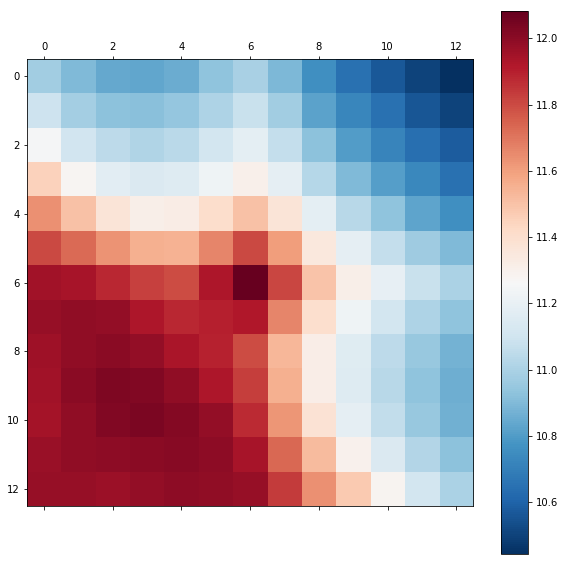

In [22]:
loop_sum = sum_loops(arr)
plot_HiC(np.log(loop_sum), figsize=(10, 10))